# SignABC - BISINDO Sign Language Learning App for Children

<div class="alert alert-block alert-success"> 
📌 This notebook is created for a capstone project, we are creating a learning app for children to help them learn about BISINDO sign language.
</div>

# Import Dependencies

In [ ]:
!pip install tensorflowjs

In [1]:
import os
import random
import shutil
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import PIL
import PIL.Image
import tensorflow_hub as hub
import tensorflowjs as tfjs

from google.colab import drive, files
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array

# Setup

In [2]:
# Mount google drive
drive.mount('/content/drive/')

# Unzip dataset file
!unzip "/content/drive/MyDrive/Capstone Project ML/Zipped dataset/Dataset paling baru.zip" -d "/content"

!rm -r '/content/Dataset-20230525T124207Z-001/Dataset/NOTHING'

Streaming output truncated to the last 5000 lines.
  inflating: /content/Dataset-20230525T124207Z-001/Dataset/G/augmented_image_11.jpg  
  inflating: /content/Dataset-20230525T124207Z-001/Dataset/G/augmented_image_12.jpg  
  inflating: /content/Dataset-20230525T124207Z-001/Dataset/G/augmented_image_13.jpg  
  inflating: /content/Dataset-20230525T124207Z-001/Dataset/G/augmented_image_14.jpg  
  inflating: /content/Dataset-20230525T124207Z-001/Dataset/G/augmented_image_15.jpg  
  inflating: /content/Dataset-20230525T124207Z-001/Dataset/G/augmented_image_16.jpg  
  inflating: /content/Dataset-20230525T124207Z-001/Dataset/G/augmented_image_17.jpg  
  inflating: /content/Dataset-20230525T124207Z-001/Dataset/G/augmented_image_18.jpg  
  inflating: /content/Dataset-20230525T124207Z-001/Dataset/G/augmented_image_19.jpg  
  inflating: /content/Dataset-20230525T124207Z-001/Dataset/G/augmented_image_2.jpg  
  inflating: /content/Dataset-20230525T124207Z-001/Dataset/G/augmented_image_20.jpg  
  in

In [3]:
# Dataset path
data_dir = pathlib.Path('/content/Dataset-20230525T124207Z-001/Dataset')

# Image count
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.JPG'))) + len(list(data_dir.glob('*/*.png'))) + len(list(data_dir.glob('*/*.PNG')))
print(image_count)

6376


# Dataset

In [4]:
# Dataset properties
batch_size = 32
img_height = 224
img_width = 224

In [5]:
# Training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6376 files belonging to 26 classes.
Using 5101 files for training.


In [6]:
# Testing dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6376 files belonging to 26 classes.
Using 1275 files for validation.


In [7]:
# Labels list
class_names = np.array(train_ds.class_names)
print(class_names)

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']


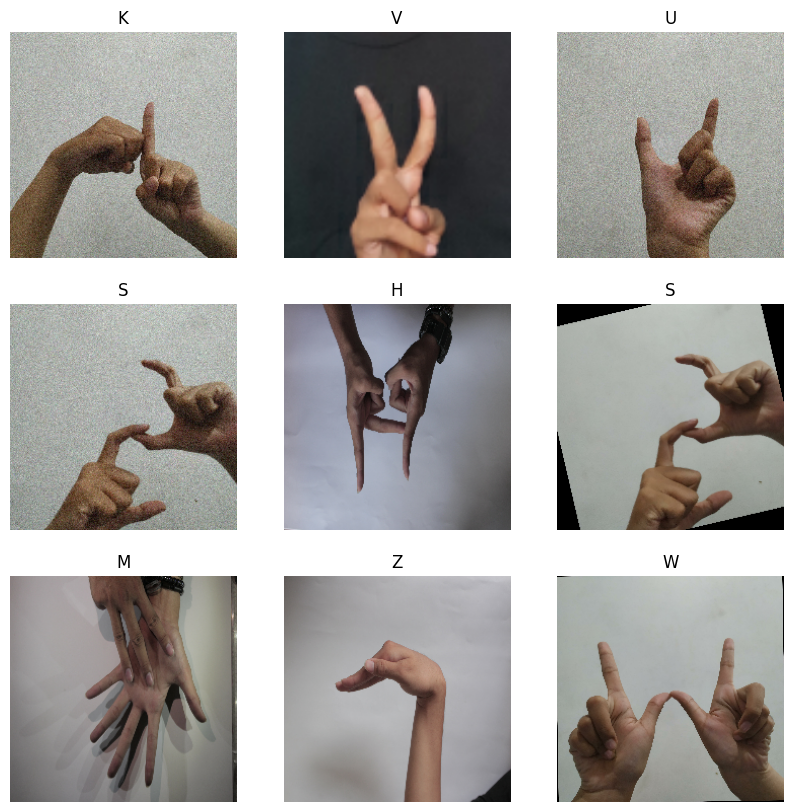

In [8]:
# Dataset sample

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
# Normalize dataset
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) 
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [10]:
# Autotune cache and paralellization to improve performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Without Transfer Learning



## Model Architecture

In [11]:
# Method to create model
def create_uncompiled_model():

    num_classes = len(class_names)

    model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(num_classes, activation = 'softmax')
    ])

    return model

## Tune Learning Rate

In [12]:
# Method to find the 'best' learning rate
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    
    optimizer = tf.keras.optimizers.Adam()
    
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [13]:
# Find the 'best' learning rate
# lr_history = adjust_learning_rate(train_ds)

In [14]:
# Plot the result
# plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
# plt.axis([1e-4, 10, 0, 10])

> The 'best' learning rate would be around 1e-3 as that area has quite stable loss compared to the other area.

## Train Model

In [15]:
model = create_uncompiled_model()

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
160/160 [==============================] - 174s 981ms/step - loss: 2.1695 - accuracy: 0.4180 - val_loss: 0.8825 - val_accuracy: 0.7576
Epoch 2/20
160/160 [==============================] - 7s 42ms/step - loss: 0.4769 - accuracy: 0.8763 - val_loss: 0.5075 - val_accuracy: 0.8824
Epoch 3/20
160/160 [==============================] - 6s 40ms/step - loss: 0.1316 - accuracy: 0.9639 - val_loss: 0.4357 - val_accuracy: 0.9051
Epoch 4/20
160/160 [==============================] - 7s 42ms/step - loss: 0.0436 - accuracy: 0.9878 - val_loss: 0.4624 - val_accuracy: 0.9263
Epoch 5/20
160/160 [==============================] - 6s 40ms/step - loss: 0.0243 - accuracy: 0.9933 - val_loss: 0.4664 - val_accuracy: 0.9145
Epoch 6/20
160/160 [==============================] - 6s 41ms/step - loss: 0.0180 - accuracy: 0.9955 - val_loss: 0.4056 - val_accuracy: 0.9263
Epoch 7/20
160/160 [==============================] - 6s 40ms/step - loss: 0.0272 - accuracy: 0.9929 - val_loss: 0.4834 - val_accuracy: 0.9

## Model Evaluation

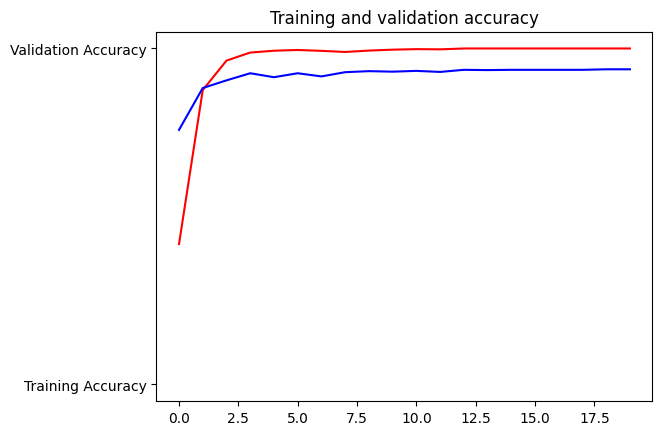

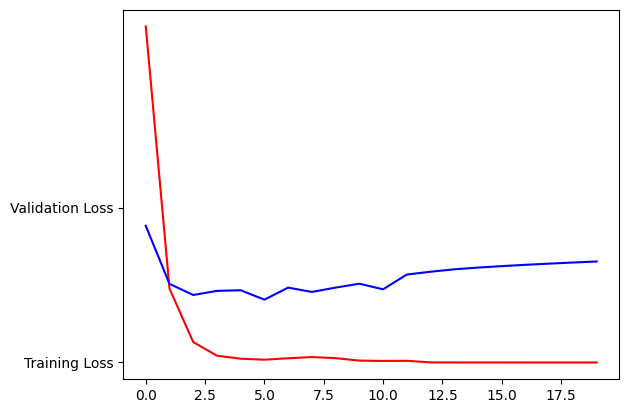

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

## Save Model

In [17]:
# export_dir = 'saved_model/without_transfer_no_nothing'
# tf.saved_model.save(model, export_dir)

# With Transfer Learning



## Load Pre-trained Model

In [18]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

In [19]:
# Create layer from pre-trained model
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

## Model Architecture

In [20]:
# Method to create model
def create_uncompiled_model():

    num_classes = len(class_names)

    model = tf.keras.Sequential([
      feature_extractor_layer,
      tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

## Tune Learning Rate

In [21]:
# Method to find the 'best' learning rate
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    
    optimizer = tf.keras.optimizers.Adam()
    
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [22]:
# Find the 'best' learning rate
# lr_history = adjust_learning_rate(train_ds)

In [23]:
# Plot the result
# plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
# plt.axis([1e-4, 10, 0, 10])

> The 'best' learning rate would be around 1e-2 as that area has quite 
stable loss compared to the other area.

## Train Model

In [45]:
model_tl = create_uncompiled_model()

model_tl.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

history = model_tl.fit(train_ds, validation_data=val_ds, epochs=15)

Epoch 1/15
160/160 [==============================] - 10s 54ms/step - loss: 0.9590 - accuracy: 0.7802 - val_loss: 0.3302 - val_accuracy: 0.9153
Epoch 2/15
160/160 [==============================] - 8s 47ms/step - loss: 0.1175 - accuracy: 0.9637 - val_loss: 0.1526 - val_accuracy: 0.9631
Epoch 3/15
160/160 [==============================] - 7s 47ms/step - loss: 0.0318 - accuracy: 0.9924 - val_loss: 0.0979 - val_accuracy: 0.9718
Epoch 4/15
160/160 [==============================] - 8s 47ms/step - loss: 0.0121 - accuracy: 0.9982 - val_loss: 0.0794 - val_accuracy: 0.9812
Epoch 5/15
160/160 [==============================] - 8s 48ms/step - loss: 0.0043 - accuracy: 0.9998 - val_loss: 0.0798 - val_accuracy: 0.9788
Epoch 6/15
160/160 [==============================] - 8s 47ms/step - loss: 0.0132 - accuracy: 0.9965 - val_loss: 0.1085 - val_accuracy: 0.9694
Epoch 7/15
160/160 [==============================] - 7s 46ms/step - loss: 0.0092 - accuracy: 0.9980 - val_loss: 0.0816 - val_accuracy: 0.975

## Model Evaluation

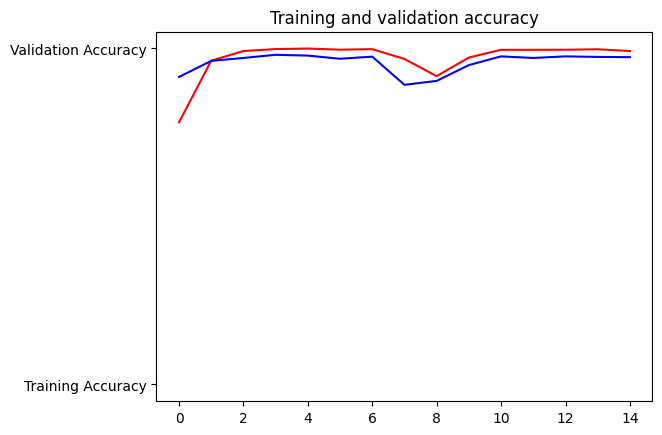

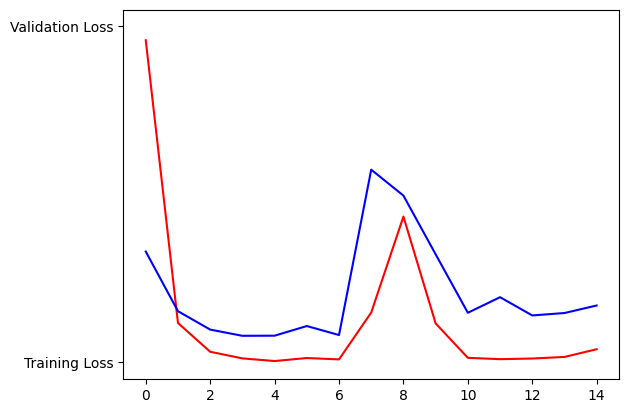

In [46]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

## Test with Uploaded Image

In [26]:
# # Upload image(s) and predict
# uploaded=files.upload()

# # Load images
# for fn in uploaded.keys():
 
#   path='/content/' + fn
#   img=load_img(path, target_size=(img_height, img_width))
  
#   x=img_to_array(img)
#   x /= 255
#   x=np.expand_dims(x, axis=0)
#   images = np.vstack([x])
  
#   # Predict 
#   predicted_batch = model.predict(images)
#   predicted_id = tf.math.argmax(predicted_batch, axis=-1)
#   predicted_label_batch = class_names[predicted_id]
#   print(predicted_label_batch)

In [73]:
# Upload manually
path = '/content/dump/Photo on 26-05-23 at 19.01 copy.jpg'

image = PIL.Image.open(path)
image = image.resize((img_height, img_width), 1)
x=img_to_array(image)
x /= 255
x=np.expand_dims(x, axis=0)
images = np.vstack([x])

predicted_batch = model_tl.predict(images)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 0s 53ms/step
M


<ipython-input-73-fc2a2d429e03>:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  predicted_label_batch = class_names[predicted_id]


## Save Model

In [51]:
export_dir = 'saved_model/inception_no_nothing_class'
tf.saved_model.save(model_tl, export_dir)

In [ ]:
# !zip -r "/content/saved_model.zip" "/content/saved_model"

In [58]:
# import time
# saved_model_path = "./{}.h5".format(int(time.time()))

# model_tl.save(saved_model_path)

In [ ]:
# !tensorflowjs_converter --input_format=keras --output_format=tfjs_graph_model inception_no_nothing_class ./